In [4]:
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from tensorflow.examples.tutorials.mnist import input_data


mnist = input_data.read_data_sets('tmp/MNIST_data', one_hot=True)
mb_size = 64
Z_dim = 100
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
h_dim = 128
cnt = 0
lr = 1e-3


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)


""" ==================== GENERATOR ======================== """

Wzh = xavier_init(size=[Z_dim + y_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)


def G(z, c):
    inputs = torch.cat([z, c], 1)
    h = nn.relu(inputs @ Wzh + bzh.repeat(inputs.size(0), 1))
    X = nn.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X


""" ==================== DISCRIMINATOR ======================== """

Wxh = xavier_init(size=[X_dim + y_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Why = xavier_init(size=[h_dim, 1])
bhy = Variable(torch.zeros(1), requires_grad=True)


def D(X, c):
    inputs = torch.cat([X, c], 1)
    h = nn.relu(inputs @ Wxh + bxh.repeat(inputs.size(0), 1))
    y = nn.sigmoid(h @ Why + bhy.repeat(h.size(0), 1))
    return y


G_params = [Wzh, bzh, Whx, bhx]
D_params = [Wxh, bxh, Why, bhy]
params = G_params + D_params


""" ===================== TRAINING ======================== """


def reset_grad():
    for p in params:
        if p.grad is not None:
            data = p.grad.data
            p.grad = Variable(data.new().resize_as_(data).zero_())


G_solver = optim.Adam(G_params, lr=1e-3)
D_solver = optim.Adam(D_params, lr=1e-3)

ones_label = Variable(torch.ones(mb_size))
zeros_label = Variable(torch.zeros(mb_size))


for it in range(100000):
    # Sample data
    z = Variable(torch.randn(mb_size, Z_dim))
    X, c = mnist.train.next_batch(mb_size)
    X = Variable(torch.from_numpy(X))
    c = Variable(torch.from_numpy(c.astype('float32')))

    # Dicriminator forward-loss-backward-update
    G_sample = G(z, c)
    D_real = D(X, c)
    D_fake = D(G_sample, c)

    D_loss_real = nn.binary_cross_entropy(D_real, ones_label)
    D_loss_fake = nn.binary_cross_entropy(D_fake, zeros_label)
    D_loss = D_loss_real + D_loss_fake

    D_loss.backward()
    D_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    # Generator forward-loss-backward-update
    z = Variable(torch.randn(mb_size, Z_dim))
    G_sample = G(z, c)
    D_fake = D(G_sample, c)

    G_loss = nn.binary_cross_entropy(D_fake, ones_label)

    G_loss.backward()
    G_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    # Print and plot every now and then
    if it % 1000 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'.format(it, D_loss.data.numpy(), G_loss.data.numpy()))

        c = np.zeros(shape=[mb_size, y_dim], dtype='float32')
        c[:, np.random.randint(0, 10)] = 1.
        c = Variable(torch.from_numpy(c))
        samples = G(z, c).data.numpy()[:16]

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('out/'):
            os.makedirs('out/')

        plt.savefig('out/{}.png'.format(str(cnt).zfill(3)), bbox_inches='tight')
        cnt += 1
        plt.close(fig)


Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting tmp/MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting tmp/MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting tmp/MNIST_data/t10k-labels-idx1-ubyte.gz


/Users/gvsi/.virtualenvs/gan/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Iter-0; D_loss: [ 1.33349252]; G_loss: [ 2.48869801]
Iter-1000; D_loss: [ 0.00156199]; G_loss: [ 8.10518837]
Iter-2000; D_loss: [ 0.01504124]; G_loss: [ 5.31819725]
Iter-3000; D_loss: [ 0.03778245]; G_loss: [ 8.59025383]
Iter-4000; D_loss: [ 0.21632931]; G_loss: [ 3.64234304]
Iter-5000; D_loss: [ 0.22219378]; G_loss: [ 4.61682892]
Iter-6000; D_loss: [ 0.46977144]; G_loss: [ 3.83009362]
Iter-7000; D_loss: [ 0.73649943]; G_loss: [ 3.16015077]
Iter-8000; D_loss: [ 0.33622453]; G_loss: [ 3.54452825]
Iter-9000; D_loss: [ 0.56718612]; G_loss: [ 3.40774465]
Iter-10000; D_loss: [ 0.80504495]; G_loss: [ 2.54718018]
Iter-11000; D_loss: [ 0.68731451]; G_loss: [ 1.78875351]
Iter-12000; D_loss: [ 0.75565088]; G_loss: [ 2.70864868]
Iter-13000; D_loss: [ 0.73045748]; G_loss: [ 2.15528035]
Iter-14000; D_loss: [ 0.70220411]; G_loss: [ 2.06548715]
Iter-15000; D_loss: [ 0.98210537]; G_loss: [ 2.16292977]
Iter-16000; D_loss: [ 0.68324411]; G_loss: [ 2.07659578]
Iter-17000; D_loss: [ 0.77837914]; G_loss: [

Variable containing:
    0     0     0     0     0     0     0     1     0     0
    0     0     0     0     0     0     0     1     0     0
    0     0     0     0     0     0     0     1     0     0
    0     0     0     0     0     0     0     1     0     0
    0     0     0     0     0     0     0     1     0     0
    0     0     0     0     0     0     0     1     0     0
    0     0     0     0     0     0     0     1     0     0
    0     0     0     0     0     0     0     1     0     0
    0     0     0     0     0     0     0     1     0     0
    0     0     0     0     0     0     0     1     0     0
    0     0     0     0     0     0     0     1     0     0
    0     0     0     0     0     0     0     1     0     0
    0     0     0     0     0     0     0     1     0     0
    0     0     0     0     0     0     0     1     0     0
    0     0     0     0     0     0     0     1     0     0
    0     0     0     0     0     0     0     1     0     0
    0     0     0  

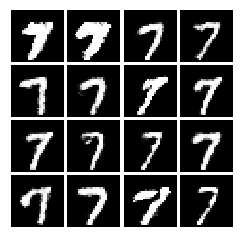

In [12]:
%matplotlib inline

c = np.zeros(shape=[mb_size, y_dim], dtype='float32')
c[:, 7] = 1.
c = Variable(torch.from_numpy(c))
print(c)
samples = G(z, c).data.numpy()[:16]

fig = plt.figure(figsize=(4, 4))
gs = gridspec.GridSpec(4, 4)
gs.update(wspace=0.05, hspace=0.05)

for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')